# Bayesian lasso logistic regression using data set imputed from Bayesian imputation using posterior predictive

In [24]:
# import package
import arviz as az
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pymc as pm
import pymc.math as pmath
import pandas as pd
from sklearn.metrics import RocCurveDisplay, auc, roc_curve


In [25]:
# load dataset 
df = pd.read_csv('diabetes_imputed.csv')
# drop the first col which is the same as id col
df = df.drop(df.columns[0], axis=1)
df.head(10) # head of the data

,Pregnancies,DiabetesPedigreeFunction,Age,Outcome,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,6,0.627,50,1,148.0,72.000,35.000,57.848,33.600
1,1,0.351,31,0,85.0,66.000,29.000,50.397,26.600
2,8,0.672,32,1,183.0,64.000,21.664,61.692,23.300
3,1,0.167,21,0,89.0,66.000,23.000,94.000,28.100
4,0,2.288,33,1,137.0,40.000,35.000,168.000,43.100
5,5,0.201,30,0,116.0,74.000,22.073,53.227,25.600
6,3,0.248,26,1,78.0,50.000,32.000,88.000,31.000
7,10,0.134,29,0,115.0,72.701,31.321,55.203,35.300
8,2,0.158,53,1,197.0,70.000,45.000,543.000,30.500
9,8,0.232,54,1,125.0,96.000,34.819,53.942,38.175


In [26]:
df.describe()

,Pregnancies,DiabetesPedigreeFunction,Age,Outcome,Glucose,BloodPressure,SkinThickness,Insulin,BMI
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,0.471876,33.240885,0.348958,121.401142,72.157525,28.763996,106.439393,32.397813
std,3.369578,0.331329,11.760232,0.476951,30.644174,12.448309,9.541511,98.888854,6.915487
min,0.000000,0.078000,21.000000,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000
25%,1.000000,0.243750,24.000000,0.000000,99.000000,64.000000,22.000000,53.307250,27.475000
50%,3.000000,0.372500,29.000000,0.000000,117.000000,72.000000,28.085500,58.956000,32.050000
75%,6.000000,0.626250,41.000000,1.000000,140.250000,80.000000,35.000000,127.250000,36.600000
max,17.000000,2.420000,81.000000,1.000000,199.000000,122.000000,99.000000,846.000000,67.100000


In [27]:
X = df.astype(float)
y = df.pop("Outcome")
# standardize the predictors
# after standardizing, the convergence looks much better
X -= X.mean()
X /= X.std()

In [28]:
X = X.drop(['Outcome'], axis=1)
X.head()

,Pregnancies,DiabetesPedigreeFunction,Age,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,0.639530,0.468187,1.425067,0.867991,-0.012654,0.653566,-0.491374,0.173840
1,-0.844335,-0.364823,-0.190548,-1.187865,-0.494647,0.024734,-0.566721,-0.838381
2,1.233077,0.604004,-0.105515,2.010133,-0.655312,-0.744117,-0.452502,-1.315571
3,-0.844335,-0.920163,-1.040871,-1.057335,-0.494647,-0.604097,-0.125792,-0.621477
4,-1.141108,5.481337,-0.020483,0.509032,-2.583285,0.653566,0.622523,1.547568


In [29]:
y.head(10)

0    1
1    0
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    1
Name: Outcome, dtype: int64

## Lasso for variables selection

D:\anaconda3\envs\pymc_env\Lib\site-packages\pymc\data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


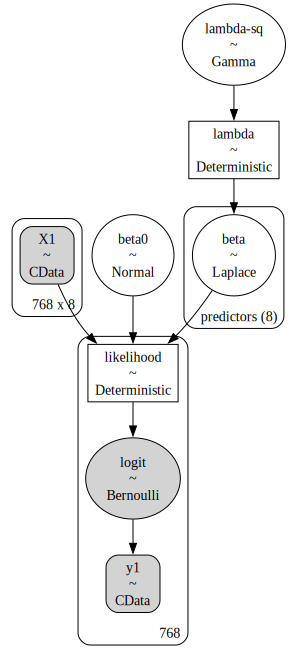

In [30]:
with pm.Model(coords={"predictors": X.columns.values}) as lasso_logistic_model:

    X1 = pm.MutableData("X1", X)
    y1 = pm.MutableData("y1", y)
    # 
    # lambda parameter for the lasso lambda ~ gamma(1,1)
    lambda_sq = pm.Gamma('lambda-sq', alpha=1, beta=1)
    lambda_param = pm.Deterministic('lambda', pmath.sqrt(lambda_sq))

    # intercept ~ normal(0,sd=100) - an uninformative prior
    # all the rest betas follow Laplacee dist wiht mu=0, and scale = lambda which follows a gamma(1,1)
    beta0 = pm.Normal('beta0', 0, sigma=100)
    beta = pm.Laplace('beta', mu=0, b=lambda_param, dims = "predictors")
   # beta2 = pymc.Laplace('beta1', mu=0, b=lambda_param)
   # beta3= pymc.Laplace('beta1', mu=0, b=lambda_param)

    # Transform random variables into vector of probabilities p(y_i=1)
    # according to logistic regression model specification.
    likelihood = pm.Deterministic("likelihood", pm.math.invlogit(beta0 + pm.math.dot(X1, beta)) )

    # Bernoulli random vector with probability of success
    # given by inverseee-logit function and actual data as observed
    pm.Bernoulli(name='logit', p=likelihood, observed=y1)
pm.model_to_graphviz(lasso_logistic_model)

In [31]:
# posterior sampling
with lasso_logistic_model:
    trace = pm.sample(10000, chains = 4, random_seed=2024, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda-sq, beta0, beta]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 45 seconds.


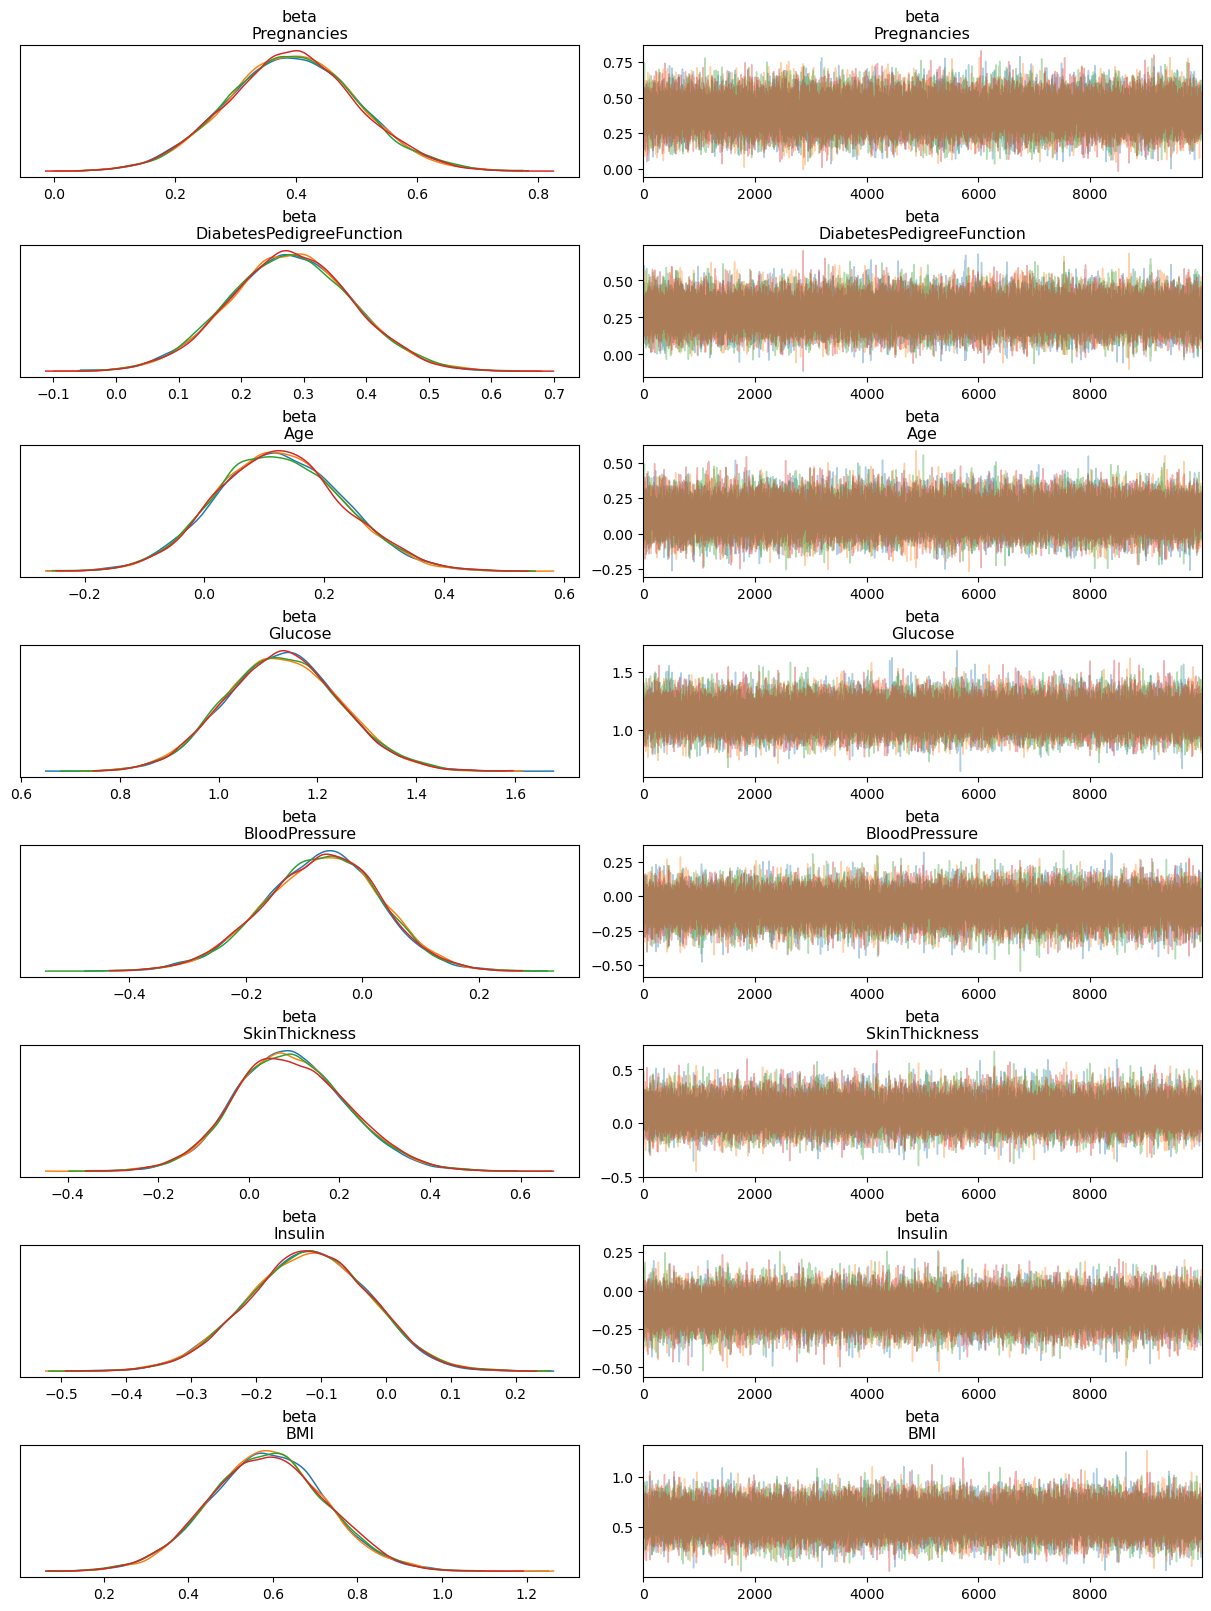

In [32]:
az.plot_trace(trace, var_names="beta", compact=False)
plt.rcParams['figure.constrained_layout.use'] = True

In [33]:
az.summary(trace, hdi_prob = 0.90, var_names="beta")

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[Pregnancies],0.394,0.107,0.216,0.570,0.000,0.000,52464.0,32315.0,1.0
beta[DiabetesPedigreeFunction],0.279,0.099,0.115,0.440,0.000,0.000,62717.0,32276.0,1.0
beta[Age],0.125,0.106,-0.045,0.303,0.000,0.000,50971.0,33201.0,1.0
beta[Glucose],1.129,0.117,0.937,1.318,0.001,0.000,49480.0,33506.0,1.0
beta[BloodPressure],-0.071,0.100,-0.238,0.089,0.000,0.000,53374.0,31383.0,1.0
beta[SkinThickness],0.094,0.124,-0.106,0.299,0.001,0.001,45184.0,30343.0,1.0
beta[Insulin],-0.120,0.094,-0.274,0.032,0.000,0.000,52722.0,33202.0,1.0
beta[BMI],0.587,0.138,0.366,0.817,0.001,0.000,43656.0,33281.0,1.0


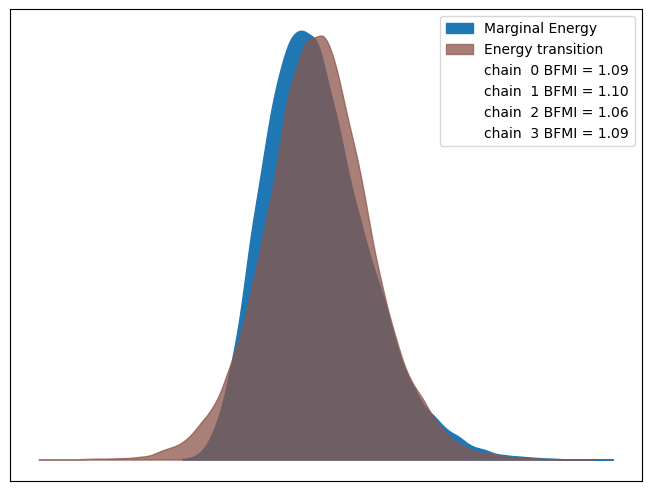

In [34]:
az.plot_energy(trace);

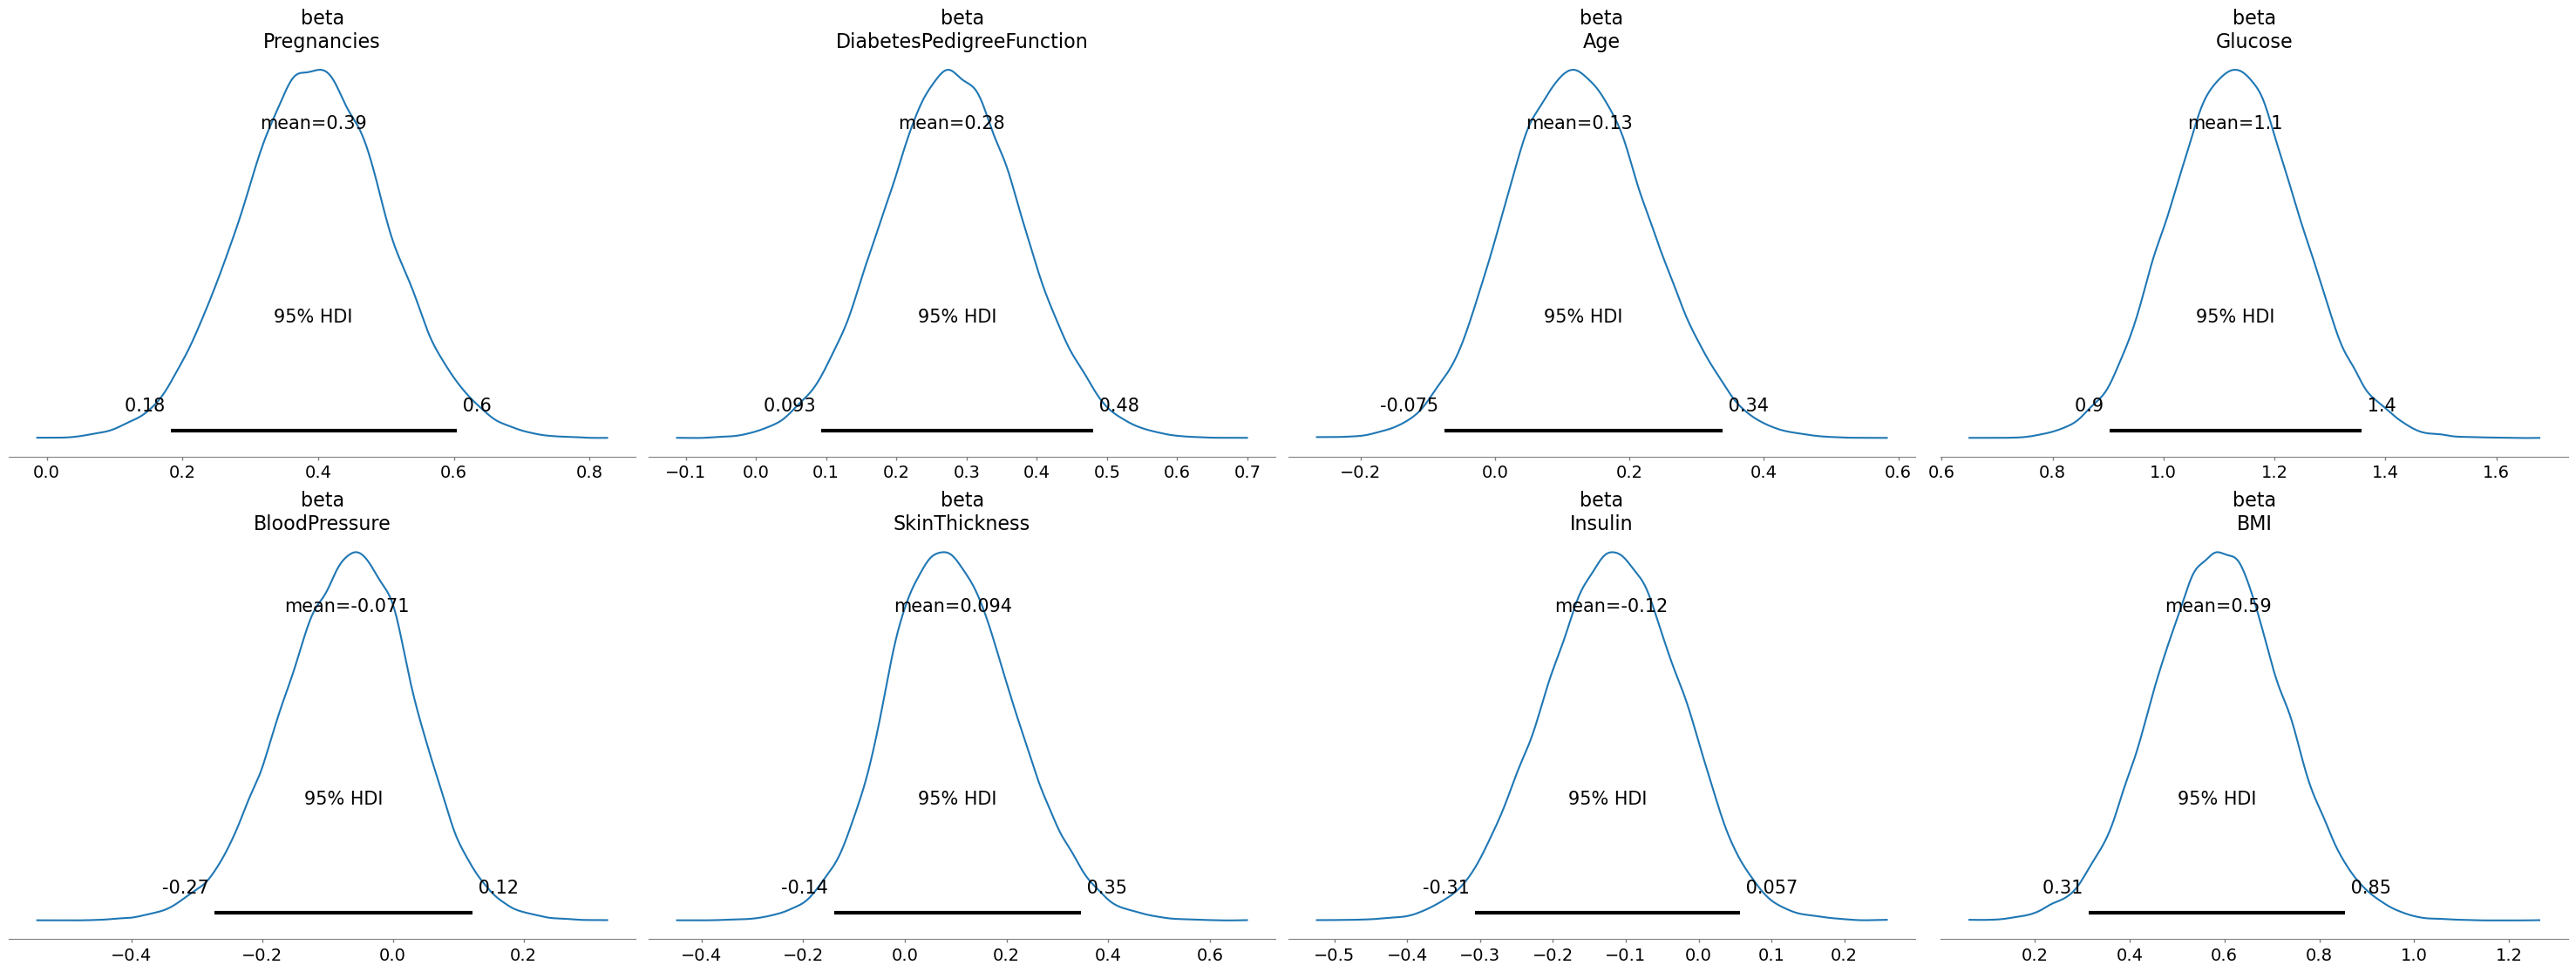

In [35]:
pm.plot_posterior(trace,var_names=["beta"], hdi_prob=0.95);

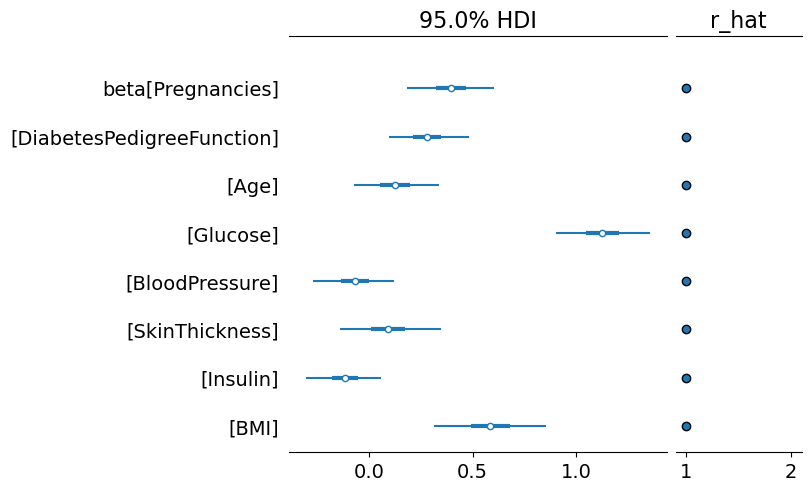

In [36]:
az.plot_forest(trace, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

# Inference 

### After seeing the plots and statistic above, we could see the beta parameters for BloodPressure and SkinThickness aree shunken close to 0. Thus, for inference, we drop these two variables 

In [37]:
X = X.drop(columns=['SkinThickness'])
X.head()

,Pregnancies,DiabetesPedigreeFunction,Age,Glucose,BloodPressure,Insulin,BMI
0,0.639530,0.468187,1.425067,0.867991,-0.012654,-0.491374,0.173840
1,-0.844335,-0.364823,-0.190548,-1.187865,-0.494647,-0.566721,-0.838381
2,1.233077,0.604004,-0.105515,2.010133,-0.655312,-0.452502,-1.315571
3,-0.844335,-0.920163,-1.040871,-1.057335,-0.494647,-0.125792,-0.621477
4,-1.141108,5.481337,-0.020483,0.509032,-2.583285,0.622523,1.547568


D:\anaconda3\envs\pymc_env\Lib\site-packages\pymc\data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


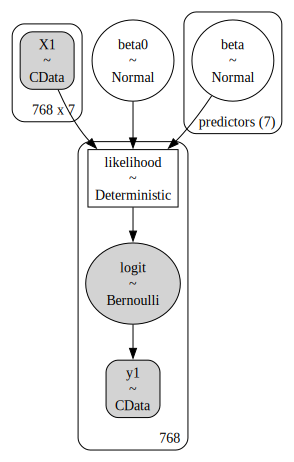

In [38]:
with pm.Model(coords={"predictors": X.columns.values}) as logistic_model:

    X1 = pm.MutableData("X1", X)
    y1 = pm.MutableData("y1", y)
    # intercept ~ normal(0,sd=100) - an uninformative prior
    beta0 = pm.Normal('beta0', 0, sigma=100)
    beta = pm.Normal('beta', mu=0, sigma=100, dims = "predictors")
   # beta2 = pymc.Laplace('beta1', mu=0, b=lambda_param)
   # beta3= pymc.Laplace('beta1', mu=0, b=lambda_param)

    # Transform random variables into vector of probabilities p(y_i=1)
    # according to logistic regression model specification.
    likelihood = pm.Deterministic("likelihood", pm.math.invlogit(beta0 + pm.math.dot(X1, beta)) )

    # Bernoulli random vector with probability of success
    # given by inverseee-logit function and actual data as observed
    pm.Bernoulli(name='logit', p=likelihood, observed=y1)
pm.model_to_graphviz(logistic_model)

In [39]:
# posterior sampling
with logistic_model:
    trace2 = pm.sample(10000, chains = 4, random_seed=2024, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 42 seconds.


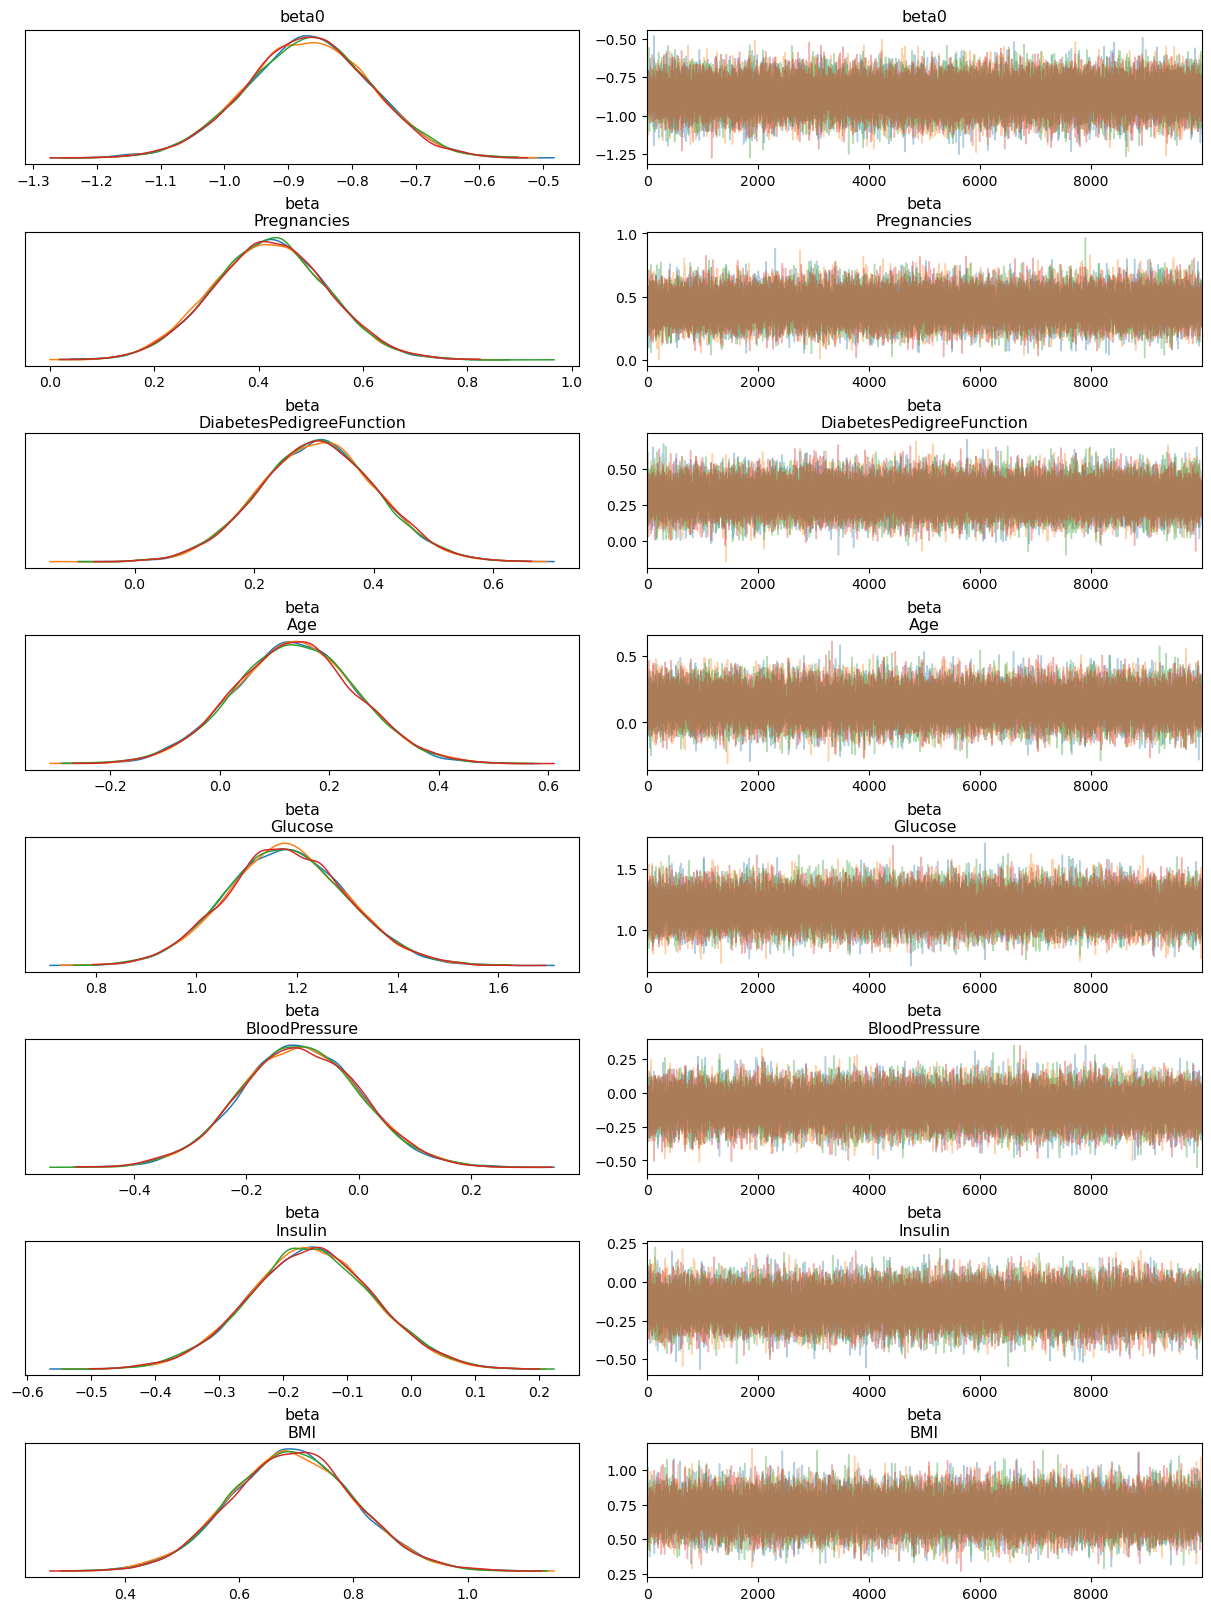

In [40]:
az.plot_trace(trace2, var_names=["beta0","beta"], compact=False)
plt.rcParams['figure.constrained_layout.use'] = True

In [41]:
az.summary(trace2, hdi_prob = 0.90, var_names=["beta0","beta"])

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-0.869,0.098,-1.026,-0.704,0.000,0.0,48908.0,33278.0,1.0
beta[Pregnancies],0.422,0.110,0.237,0.599,0.001,0.0,45942.0,32910.0,1.0
beta[DiabetesPedigreeFunction],0.306,0.099,0.144,0.468,0.000,0.0,49565.0,30863.0,1.0
beta[Age],0.137,0.112,-0.044,0.326,0.001,0.0,44657.0,33517.0,1.0
beta[Glucose],1.178,0.120,0.978,1.372,0.001,0.0,45421.0,34669.0,1.0
beta[BloodPressure],-0.105,0.108,-0.276,0.077,0.000,0.0,47029.0,34919.0,1.0
beta[Insulin],-0.156,0.098,-0.314,0.010,0.000,0.0,44614.0,32972.0,1.0
beta[BMI],0.694,0.109,0.517,0.875,0.001,0.0,44687.0,32035.0,1.0


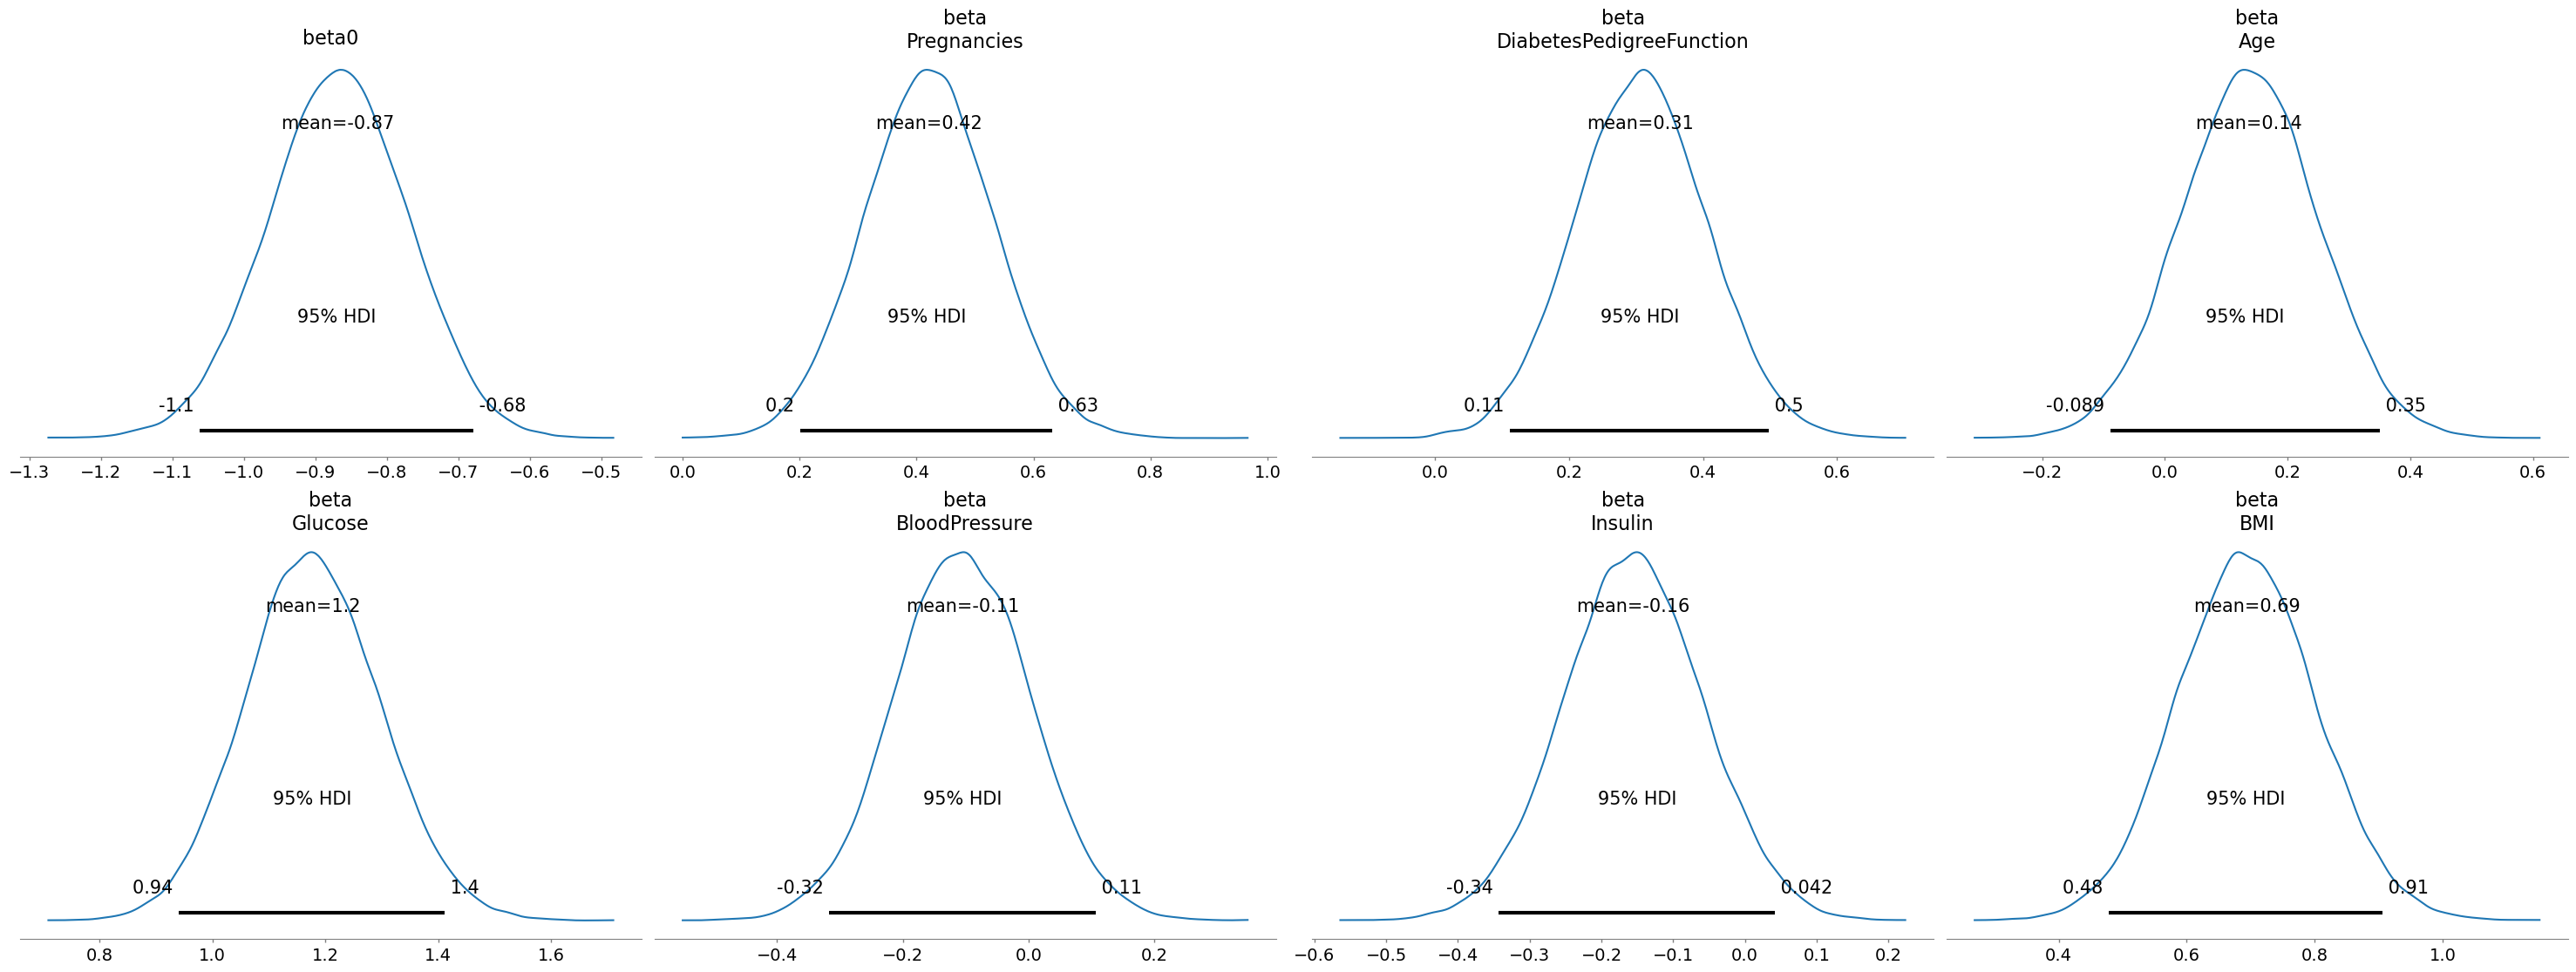

In [42]:
pm.plot_posterior(trace2,var_names=["beta0","beta"], hdi_prob=0.95);

## AUC and ROC 

In [43]:
y_score = np.mean(trace2.posterior.likelihood[0], axis=0)

In [44]:
logistic_model_prediction=[1 if x >0.5 else 0 for x in y_score]

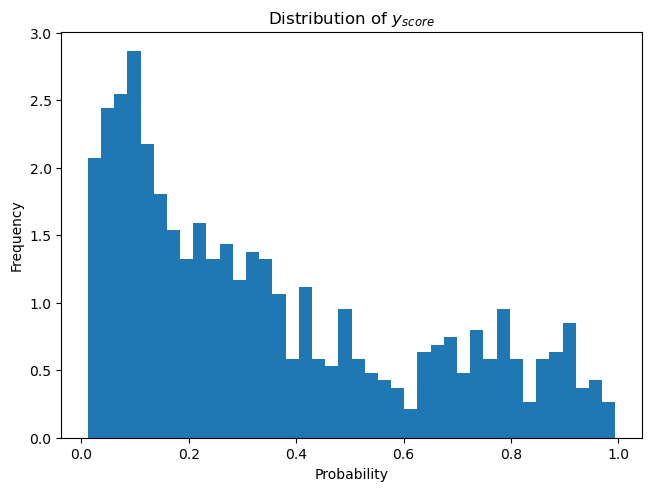

In [45]:

plt.hist(y_score, bins=40, density=True)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of $y_{score}$')
plt.show()

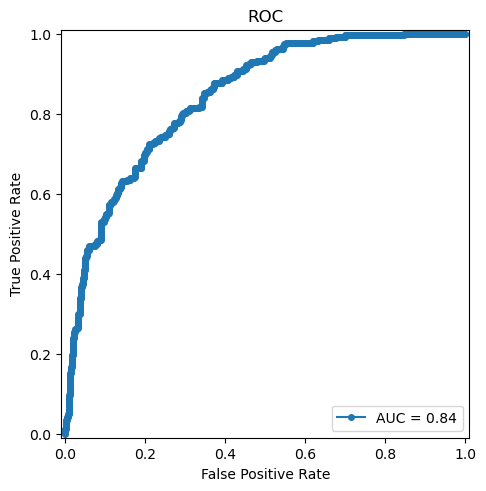

In [46]:
fpr, tpr, thresholds = roc_curve(
    y_true=y, y_score=y_score, pos_label=1, drop_intermediate=False
)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display = roc_display.plot(ax=ax, marker="o", markersize=4)
ax.set(title="ROC");